In [109]:
# !pip install openai
# !pip install tiktoken

In [2]:
import openai
import pandas as pd
import numpy as np
import tiktoken
import datetime
from IPython.display import Image

In [3]:
f = open("/content/sample_data/OPENAI_API_KEY.txt", "r")
# f = open("OPENAI_API_KEY.txt", "r")
openai_api_key = f.read()
# print(openai_api_key)
client = openai.OpenAI(api_key=openai_api_key)

In [4]:
llm_model = "gpt-3.5-turbo"

In [5]:
def get_completion_and_token_count(prompt,
                                   model=llm_model,
                                   temperature=0,
                                   max_tokens=500):
    messages = [{"role": "user", "content": prompt+' output in JSON format'}]
    response = client.chat.completions.create(
        model=model,
        messages=messages,        # messages = [{"role": "user", "content": prompt}], a list of messages comprising the conversation so far.
        temperature=temperature,
        max_tokens=max_tokens,    # The maximum number of tokens that can be 'generated' by the chat completion.
    )

    content = response.choices[0].message.content

    token_dict = {
        'prompt_tokens':response.usage.prompt_tokens, # no. of input tokens counted by OpenAI API
        'completion_tokens':response.usage.completion_tokens,
        'total_tokens':response.usage.total_tokens,
    }
    print(response)
    print(content)
    print(token_dict)

    return response, content, token_dict

In [6]:
response, content, token_dict = get_completion_and_token_count("What is 1+1?")

ChatCompletion(id='chatcmpl-93pyKAsGZwEJJFCsovwq3v1H3Cn4v', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='{\n  "result": 2\n}', role='assistant', function_call=None, tool_calls=None))], created=1710701792, model='gpt-3.5-turbo-0125', object='chat.completion', system_fingerprint='fp_4f2ebda25a', usage=CompletionUsage(completion_tokens=9, prompt_tokens=18, total_tokens=27))
{
  "result": 2
}
{'prompt_tokens': 18, 'completion_tokens': 9, 'total_tokens': 27}


In [7]:
encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")
encoding.encode("What is 1+1?") # no. of input tokens counted by OpenAI API

[3923, 374, 220, 16, 10, 16, 30]

# ***Chat API : LangChain***

In [110]:
# !pip install langchain

# Model

In [10]:
from langchain.chat_models import ChatOpenAI

In [11]:
import os
os.environ['OPENAI_API_KEY'] = openai_api_key # MUST
# To control the randomness and creativity of the generated text by an LLM, use temperature = 0.0
chat = ChatOpenAI(temperature=0.0, model=llm_model)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.chat_models.openai.ChatOpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


# Prompt template - Input into the model

In [12]:
template_string = """Translate the text \
that is delimited by triple backticks \
into a style that is {style}. \
text: ```{text}```
"""

In [13]:
from langchain.prompts import ChatPromptTemplate
prompt_template = ChatPromptTemplate.from_template(template_string)

In [14]:
print(prompt_template.messages[0].prompt)
print(prompt_template.messages[0].prompt.input_variables)

input_variables=['style', 'text'] template='Translate the text that is delimited by triple backticks into a style that is {style}. text: ```{text}```\n'
['style', 'text']


In [15]:
customer_email = """
Hi how are you doing
"""
customer_style = """Spanish \
in a calm and respectful tone
"""
customer_messages = prompt_template.format_messages(
                    style=customer_style,
                    text=customer_email)

In [16]:
print(type(customer_messages))
print(customer_messages)
print(type(customer_messages[0]))
print(customer_messages[0])

<class 'list'>
[HumanMessage(content='Translate the text that is delimited by triple backticks into a style that is Spanish in a calm and respectful tone\n. text: ```\nHi how are you doing\n```\n')]
<class 'langchain_core.messages.human.HumanMessage'>
content='Translate the text that is delimited by triple backticks into a style that is Spanish in a calm and respectful tone\n. text: ```\nHi how are you doing\n```\n'


In [17]:
# Call the LLM to translate to the style of the customer message
customer_response = chat(customer_messages)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.7 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


In [18]:
print(customer_response.content)

Hola, ¿cómo estás?


# Parse the LLM output

In [19]:
from langchain.output_parsers import ResponseSchema
from langchain.output_parsers import StructuredOutputParser

In [20]:
email_body_schema = ResponseSchema(name="email_body",
                                      description="Extract email body")

email_from_schema = ResponseSchema(name="email_sender",
                                      description="Extract sender email")

email_from_name_schema = ResponseSchema(name="email_sender_name",
                                      description="Extract sender name")

email_from_designation_schema = ResponseSchema(name="email_sender_designation",
                                      description="Extract sender designation")

email_from_organization_schema = ResponseSchema(name="email_sender_organization",
                                      description="Extract sender orgaization")

email_date_schema = ResponseSchema(name="email_date",
                                       description="Extract email date")

email_to_schema = ResponseSchema(name="email_recipients",
                                      description="Extract comma separated email recipients")

response_schemas = [email_from_schema,
                    email_from_name_schema,
                    email_from_designation_schema,
                    email_from_organization_schema,
                    email_to_schema,
                    email_date_schema,
                    email_body_schema]

In [21]:
output_parser = StructuredOutputParser.from_response_schemas(response_schemas)

In [22]:
format_instructions = output_parser.get_format_instructions()
print(format_instructions)

The output should be a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":

```json
{
	"email_sender": string  // Extract sender email
	"email_sender_name": string  // Extract sender name
	"email_sender_designation": string  // Extract sender designation
	"email_sender_organization": string  // Extract sender orgaization
	"email_recipients": string  // Extract comma separated email recipients
	"email_date": string  // Extract email date
	"email_body": string  // Extract email body
}
```


In [23]:
email = "From: Doe, John <JohnDoe@xyz.com> \
Sent: Wednesday, March 15, 2023 11:21 PM \
To: Hollester, Mike <@MHollester.com>; Parrera, Nicky <NParrera@xyz.com> \
Cc: Bush, Johnny <JBush@xyz.com>; Herding, Bill <BHerding@xyz.com> \
Subject: RE: Interested in AI product  \
I hope this email finds you well. \
I am reaching out to inquire about your company's AI offerings and services. \
Could you please provide more information regarding your capabilities and solutions in this field? \
Shawn Ponting \
Senior Product Manager \
Great Corporation"

In [24]:
review_template_2 = """\
For the following text, extract the following information:

email_body: Extract email body If this information is not found,output Unknown Email Body
email_sender: Extract sender email If this information is not found, output Unknown Sender.
email_sender_designation: Extract sender designation If this information is not found, output Unknown Sender Designation.
email_sender_organization: Extract sender organization If this information is not found, output Unknown Sender Organization.
email_date: Extract email date If this information is not found, output Unknown Date.
email_recipients: Extract comma separated email recipients If this information is not found, output Unknown Recipients.

text: {text}

{format_instructions}
"""

In [25]:
prompt = ChatPromptTemplate.from_template(template=review_template_2)

messages = prompt.format_messages(text=email,
                                format_instructions=format_instructions)

In [26]:
print(messages[0].content)

For the following text, extract the following information:

email_body: Extract email body If this information is not found,output Unknown Email Body
email_sender: Extract sender email If this information is not found, output Unknown Sender.
email_sender_designation: Extract sender designation If this information is not found, output Unknown Sender Designation.
email_sender_organization: Extract sender organization If this information is not found, output Unknown Sender Organization.
email_date: Extract email date If this information is not found, output Unknown Date.
email_recipients: Extract comma separated email recipients If this information is not found, output Unknown Recipients.

text: From: Doe, John <JohnDoe@xyz.com> Sent: Wednesday, March 15, 2023 11:21 PM To: Hollester, Mike <@MHollester.com>; Parrera, Nicky <NParrera@xyz.com> Cc: Bush, Johnny <JBush@xyz.com>; Herding, Bill <BHerding@xyz.com> Subject: RE: Interested in AI product  I hope this email finds you well. I am reach

In [27]:
response = chat(messages)

In [28]:
print(response.content)

```json
{
	"email_sender": "JohnDoe@xyz.com",
	"email_sender_name": "Doe, John",
	"email_sender_designation": "Senior Product Manager",
	"email_sender_organization": "Great Corporation",
	"email_recipients": "Hollester, Mike <@MHollester.com>, Parrera, Nicky <NParrera@xyz.com>, Bush, Johnny <JBush@xyz.com>, Herding, Bill <BHerding@xyz.com>",
	"email_date": "Wednesday, March 15, 2023 11:21 PM",
	"email_body": "I hope this email finds you well. I am reaching out to inquire about your company's AI offerings and services. Could you please provide more information regarding your capabilities and solutions in this field?"
}
```


In [29]:
output_dict = output_parser.parse(response.content)

In [30]:
output_dict

{'email_sender': 'JohnDoe@xyz.com',
 'email_sender_name': 'Doe, John',
 'email_sender_designation': 'Senior Product Manager',
 'email_sender_organization': 'Great Corporation',
 'email_recipients': 'Hollester, Mike <@MHollester.com>, Parrera, Nicky <NParrera@xyz.com>, Bush, Johnny <JBush@xyz.com>, Herding, Bill <BHerding@xyz.com>',
 'email_date': 'Wednesday, March 15, 2023 11:21 PM',
 'email_body': "I hope this email finds you well. I am reaching out to inquire about your company's AI offerings and services. Could you please provide more information regarding your capabilities and solutions in this field?"}

# LangChain: Memory

### Memory of history in a chat keeps on appending by Langchain!

In [31]:
from langchain.chat_models import ChatOpenAI
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory

In [32]:
llm = ChatOpenAI(temperature=0.0, model=llm_model)
memory = ConversationBufferMemory()
conversation = ConversationChain(
    llm=llm,
    memory = memory,
    verbose=True
)

In [33]:
conversation.predict(input="Hi, this is a LangChain tutorial to explain Memory for chat application")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:

Human: Hi, this is a LangChain tutorial to explain Memory for chat application
AI:

> Finished chain.


"Hello! I'm excited to help you understand Memory for chat applications. Memory in this context refers to the ability of the chat application to remember past interactions and information shared by users. This can include things like user preferences, past conversations, and any other relevant data that can enhance the user experience. Would you like me to provide more specific details or examples?"

In [34]:
conversation.predict(input="I will use simple examples to explain Langchain Memory ")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
Human: Hi, this is a LangChain tutorial to explain Memory for chat application
AI: Hello! I'm excited to help you understand Memory for chat applications. Memory in this context refers to the ability of the chat application to remember past interactions and information shared by users. This can include things like user preferences, past conversations, and any other relevant data that can enhance the user experience. Would you like me to provide more specific details or examples?
Human: I will use simple examples to explain Langchain Memory 
AI:

> Finished chain.


"That sounds like a great idea! Using simple examples can really help clarify how Memory works in LangChain. For instance, you could explain how the chat application remembers a user's favorite color or their preferred language. These small details can make a big difference in personalizing the user experience. Let me know if you need any more examples or information!"

In [35]:
conversation.predict(input="What are we going to learn in this tutorial?")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
Human: Hi, this is a LangChain tutorial to explain Memory for chat application
AI: Hello! I'm excited to help you understand Memory for chat applications. Memory in this context refers to the ability of the chat application to remember past interactions and information shared by users. This can include things like user preferences, past conversations, and any other relevant data that can enhance the user experience. Would you like me to provide more specific details or examples?
Human: I will use simple examples to explain Langchain Memory 
AI: That sounds like a great idea! Using simple examples can really help clarify how Memory works in LangChain. For instance, you 

"In this tutorial, we will learn about how Memory works in LangChain for chat applications. We will explore how the chat application can store and retrieve user data, such as preferences and past interactions. We will also discuss the importance of Memory in enhancing the user experience and personalizing interactions. Additionally, we will cover how to implement Memory in your own chat application using LangChain. If you have any specific questions or topics you'd like to focus on, feel free to let me know!"

In [36]:
print(memory.buffer) # History

Human: Hi, this is a LangChain tutorial to explain Memory for chat application
AI: Hello! I'm excited to help you understand Memory for chat applications. Memory in this context refers to the ability of the chat application to remember past interactions and information shared by users. This can include things like user preferences, past conversations, and any other relevant data that can enhance the user experience. Would you like me to provide more specific details or examples?
Human: I will use simple examples to explain Langchain Memory 
AI: That sounds like a great idea! Using simple examples can really help clarify how Memory works in LangChain. For instance, you could explain how the chat application remembers a user's favorite color or their preferred language. These small details can make a big difference in personalizing the user experience. Let me know if you need any more examples or information!
Human: What are we going to learn in this tutorial?
AI: In this tutorial, we wi

In [37]:
# Provide additional context
today_date = str(datetime.date.today())
memory.save_context({"input": "What is the date today?" },
                    {"output": today_date})

In [38]:
memory.load_memory_variables({})

{'history': "Human: Hi, this is a LangChain tutorial to explain Memory for chat application\nAI: Hello! I'm excited to help you understand Memory for chat applications. Memory in this context refers to the ability of the chat application to remember past interactions and information shared by users. This can include things like user preferences, past conversations, and any other relevant data that can enhance the user experience. Would you like me to provide more specific details or examples?\nHuman: I will use simple examples to explain Langchain Memory \nAI: That sounds like a great idea! Using simple examples can really help clarify how Memory works in LangChain. For instance, you could explain how the chat application remembers a user's favorite color or their preferred language. These small details can make a big difference in personalizing the user experience. Let me know if you need any more examples or information!\nHuman: What are we going to learn in this tutorial?\nAI: In th

In [39]:
# Remember just 'LAST K converstaions' instead of entire history to avoid sending entire conversation to OpenAI API
from langchain.memory import ConversationBufferWindowMemory
memory = ConversationBufferWindowMemory(k=1)

In [40]:
# Provide additional context
today_date = str(datetime.date.today())
memory.save_context({"input": "What is your City of residenc?" },
                    {"output": "Delhi"})
memory.save_context({"input": "What is your Country of residence?" },
                    {"output": "India"})

In [41]:
memory.load_memory_variables({})

{'history': 'Human: What is your Country of residence?\nAI: India'}

In [42]:
# llm = ChatOpenAI(temperature=0.0, model=llm_model)
# memory =  ConversationBufferWindowMemory(k=1)  # usage
# conversation = ConversationChain(
#     llm=llm,
#     memory = memory,
#     verbose=True
# )

In [43]:
# Limit the # of tokens to send instead of entire history
from langchain.memory import ConversationTokenBufferMemory
from langchain.llms import OpenAI
llm = ChatOpenAI(temperature=0.0, model=llm_model)

In [44]:
memory = ConversationTokenBufferMemory(llm=llm, max_token_limit=20)
memory.save_context({"input": "What is your City of residence?" },
                    {"output": "Delhi"})
memory.save_context({"input": "What is your Country of residence?" },
                    {"output": "India"})
memory.save_context({"input": "Which city is your office located?" },
                    {"output": "New York"})

In [45]:
memory.load_memory_variables({})

{'history': 'AI: New York'}

In [46]:
# Instead of limiting fixed # of token, lets use LLM to write the summary of conversation so far and remem the summary
from langchain.memory import ConversationSummaryBufferMemory
memory = ConversationSummaryBufferMemory(llm=llm, max_token_limit=30)
# entire hostory so far will be summarized in max 30 token
memory.save_context({"input": "What is your City of residence?" },
                    {"output": "Delhi"})
memory.save_context({"input": "What is your Country of residence?" },
                    {"output": "India"})
memory.save_context({"input": "Which city is your office located?" },
                    {"output": "New York"})
memory.save_context({"input": "What is the date today?" },
                    {"output": today_date})

In [47]:
memory.load_memory_variables({})

{'history': 'System: The human asks the AI\'s City of residence, to which the AI responds "Delhi." When asked for the AI\'s Country of residence, the AI replies "India." The human then inquires about the city where the AI\'s office is located, and the AI responds with "New York."\nHuman: What is the date today?\nAI: 2024-03-17'}

In [48]:
conversation = ConversationChain(
    llm=llm,
    memory = memory,
    verbose=True
)

In [49]:
# Q/A or chat using history/memory
conversation.predict(input="What is the office location city?")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
System: The human asks the AI's City of residence, to which the AI responds "Delhi." When asked for the AI's Country of residence, the AI replies "India." The human then inquires about the city where the AI's office is located, and the AI responds with "New York."
Human: What is the date today?
AI: 2024-03-17
Human: What is the office location city?
AI:

> Finished chain.


'New York'

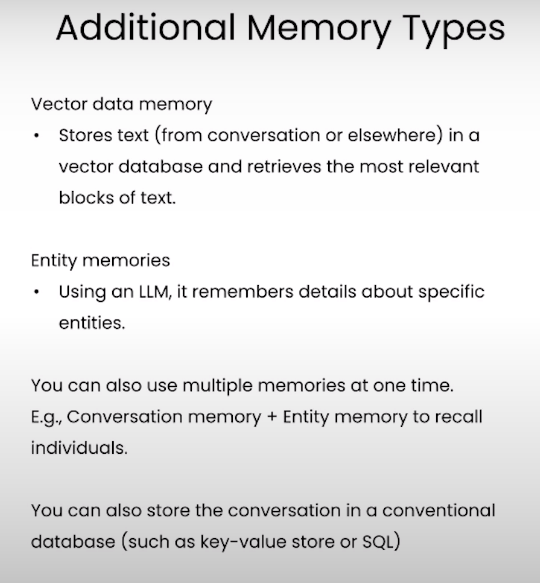

In [50]:
Image(filename='/content/sample_data/img1.png')

# LLM Chains

In [51]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain

In [52]:
llm = ChatOpenAI(temperature=0.0, model=llm_model)

In [53]:
email = "From: Ponting, Shawn <SPonting@abc.com> \
Sent: Wednesday, March 15, 2023 11:21 PM \
To: Hollester, Mike <MHollester@xyz.com> \
Subject: RE: Interested in AI product  \
I hope this email finds you well. \
I am reaching out to inquire about your company's AI offerings and services. \
Could you please provide more information regarding your capabilities and solutions in this field? \
Shawn Ponting \
Senior Product Manager \
Great Corporation"

In [54]:
prompt = ChatPromptTemplate.from_template(
    "Extract sender email from {email}?"
)

In [55]:
chain = LLMChain(llm=llm, prompt=prompt)

In [56]:
chain.run(email)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


'SPonting@abc.com'

In [57]:
# SimpleSequentialChain output of first chain is passed as input to second chain
from langchain.chains import SimpleSequentialChain
llm = ChatOpenAI(temperature=0.9, model=llm_model)

# prompt template 1
first_prompt = ChatPromptTemplate.from_template(
    "Extract sender details from {email}?"
)

# Chain 1
chain_one = LLMChain(llm=llm, prompt=first_prompt)

In [58]:
# prompt template 2
second_prompt = ChatPromptTemplate.from_template(
    "Extract sender email from {response}?"
)
# chain 2
chain_two = LLMChain(llm=llm, prompt=second_prompt)

In [59]:
overall_simple_chain = SimpleSequentialChain(chains=[chain_one, chain_two],
                                             verbose=True
                                            )

In [60]:
overall_simple_chain.run(email)



> Entering new SimpleSequentialChain chain...
Sender Details:
Name: Shawn Ponting
Title: Senior Product Manager
Company: Great Corporation
Email: SPonting@abc.com
The sender email is SPonting@abc.com.

> Finished chain.


'The sender email is SPonting@abc.com.'

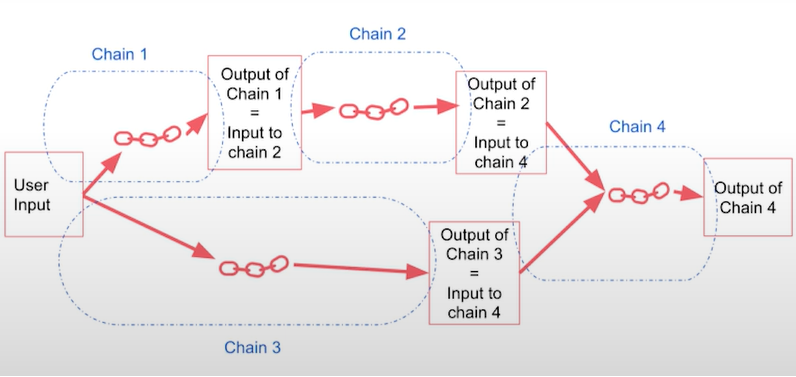

In [61]:
Image(filename='/content/sample_data/img2.png')

In [62]:
# SequentialChain - If multiple inputs and outputs and take inputs from previous chain and pass as outputs to next chain
from langchain.chains import SequentialChain
llm = ChatOpenAI(temperature=0.0, model=llm_model)

# prompt template 1:
first_prompt = ChatPromptTemplate.from_template(
    "Extract sender details from {email}"
)
# chain 1:
chain_one = LLMChain(llm=llm, prompt=first_prompt,
                     output_key="sender_details"
                    )

# prompt template 2
second_prompt = ChatPromptTemplate.from_template(
    "Extract receiver details from {email}"
)
# chain 2
chain_two = LLMChain(llm=llm, prompt=second_prompt,
                    output_key="receiver_details")

# prompt template 3
third_prompt = ChatPromptTemplate.from_template(
    "Draft reply using context provided in email using sender and receiver details: "
    "\n\sender: {receiver_details}\n\nreceiver: {sender_details}\n\nemail: {email}"
)
# chain 3
chain_three = LLMChain(llm=llm, prompt=third_prompt,
                    output_key="reply")

# overall_chain: input= Review
# and output= English_Review,summary, followup_message
overall_chain = SequentialChain(
    chains=[chain_one, chain_two, chain_three],
    input_variables=["email"],
    output_variables=["receiver_details", "sender_details","reply"],
    verbose=True
)

In [63]:
overall_chain(email)



> Entering new SequentialChain chain...


/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(



> Finished chain.


{'email': "From: Ponting, Shawn <SPonting@abc.com> Sent: Wednesday, March 15, 2023 11:21 PM To: Hollester, Mike <MHollester@xyz.com> Subject: RE: Interested in AI product  I hope this email finds you well. I am reaching out to inquire about your company's AI offerings and services. Could you please provide more information regarding your capabilities and solutions in this field? Shawn Ponting Senior Product Manager Great Corporation",
 'receiver_details': 'Receiver details:\nName: Mike Hollester\nEmail: MHollester@xyz.com',
 'sender_details': 'Sender details:\nName: Shawn Ponting\nEmail: SPonting@abc.com\nPosition: Senior Product Manager\nCompany: Great Corporation',
 'reply': "Dear Shawn Ponting,\n\nThank you for reaching out regarding our company's AI offerings and services. We appreciate your interest in learning more about our capabilities and solutions in this field. \n\nI will gather the necessary information and provide you with a detailed overview of our AI products and service

# LangChain: Q&A over Documents

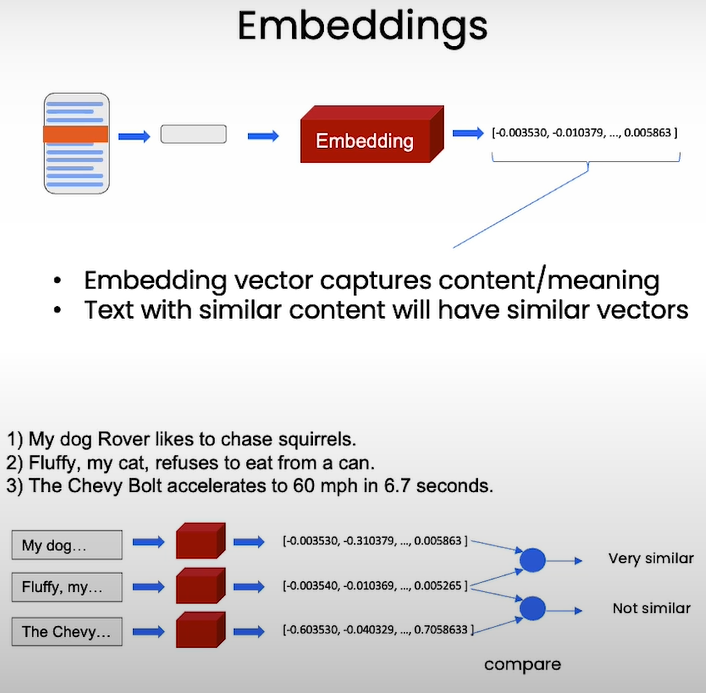

In [64]:
Image(filename='/content/sample_data/img3.png')

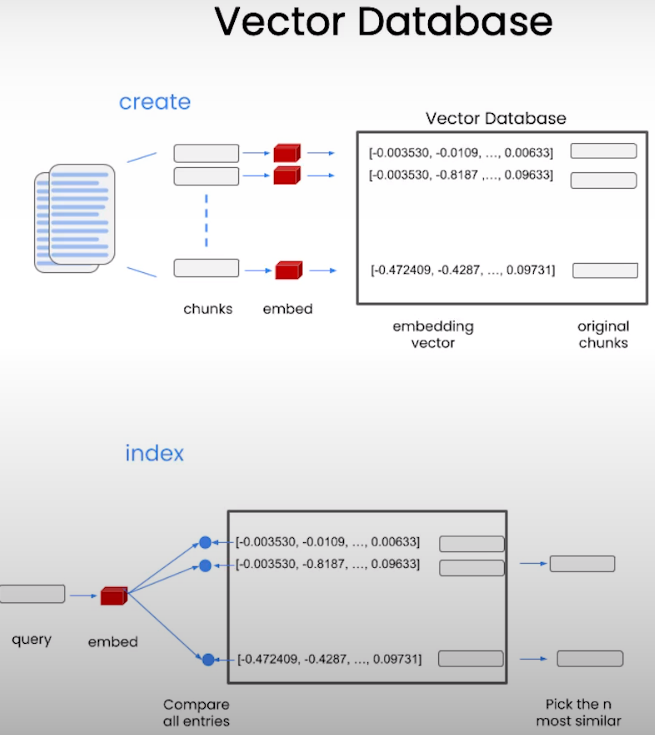

In [65]:
Image(filename='/content/sample_data/img4.png')

In [66]:
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import CSVLoader

# In-memory 'vector store' for doesnt require connecting to external vector databases - good starting point for small datasets
from langchain.vectorstores import DocArrayInMemorySearch

from IPython.display import display, Markdown
from langchain.llms import OpenAI

In [67]:
file = '/content/sample_data/all_short_clauses_test.csv'
loader = CSVLoader(file_path=file)

In [68]:
docs = loader.load()
print(docs[0])
print(len(docs))

page_content='clause: Any provision for the benefit of the Company contained in this Agreement may be waived, either generally or in any particular instance, by the Board.\ncategory: Waivers' metadata={'source': '/content/sample_data/all_short_clauses_test.csv', 'row': 0}
430


In [69]:
loader

In [70]:
from langchain.indexes import VectorstoreIndexCreator

In [71]:
!pip install docarray

In [72]:
index = VectorstoreIndexCreator(
    vectorstore_cls=DocArrayInMemorySearch  # Vector store to use
).from_loaders([loader])                    # Data store loader

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.embeddings.openai.OpenAIEmbeddings` was deprecated in langchain-community 0.0.9 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/pydantic/_migration.py:283: UserWarning: `pydantic.error_wrappers:ValidationError` has been moved to `pydantic:ValidationError`.
  warnings.warn(f'`{import_path}` has been moved to `{new_location}`.')


In [73]:
query ="Please list all your clauses of Enforceability type"

In [74]:
llm_replacement_model = OpenAI(temperature=0,
                               model='gpt-3.5-turbo-instruct')

response = index.query(query, llm = llm_replacement_model)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.llms.openai.OpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAI`.
  warn_deprecated(


In [75]:
response

' The clauses of Enforceability type are: \n1. The provisions of this Agreement are intended to be and shall be enforceable under Section 510(a) of the Bankruptcy Code.\n2. This Lease constitutes the legal, valid and binding obligation of Lessor, enforceable against Lessor in accordance with its terms.\n3. This Amendment shall inure to the benefit of and be enforceable against each of the Parties and their respective successors and assigns.'

In [76]:
display(Markdown(response))

 The clauses of Enforceability type are: 
1. The provisions of this Agreement are intended to be and shall be enforceable under Section 510(a) of the Bankruptcy Code.
2. This Lease constitutes the legal, valid and binding obligation of Lessor, enforceable against Lessor in accordance with its terms.
3. This Amendment shall inure to the benefit of and be enforceable against each of the Parties and their respective successors and assigns.

In [77]:
from langchain.embeddings import OpenAIEmbeddings # create embeddings
embeddings = OpenAIEmbeddings()

In [78]:
embed = embeddings.embed_query("Hi my name is Amit")
print(len(embed))
print(embed[:5])

1536
[-0.015661792324786667, -0.014691820825913521, -0.02058924295695532, -0.01784745918798908, -0.027029846854939074]


In [79]:
# Create vector store
db = DocArrayInMemorySearch.from_documents(
    docs,
    embeddings
)

In [80]:
query = "Please list all clauses of Erisa type"

In [81]:
docs = db.similarity_search(query)
len(docs)

4

In [82]:
list(docs)

[Document(page_content='clause: Employee Retirement Income Security Act of 1974, as amended, and the rules and regulations promulgated thereunder.\ncategory: Erisa', metadata={'source': '/content/sample_data/all_short_clauses_test.csv', 'row': 6}),
 Document(page_content='clause: The Employee Retirement Income Security Act of 1974, as amended from time to time, and as interpreted by applicable regulations and rulings.\ncategory: Erisa', metadata={'source': '/content/sample_data/all_short_clauses_test.csv', 'row': 8}),
 Document(page_content='clause: Create or maintain any Pension Plans or incur any withdrawal liability to any Multiemployer Plan (as defined in Section 5.13 ).\ncategory: Erisa', metadata={'source': '/content/sample_data/all_short_clauses_test.csv', 'row': 7}),
 Document(page_content='clause: ERISA means the Employee Retirement Income Security Act of 1974, as amended, and includes applicable DOL regulations.\ncategory: Erisa', metadata={'source': '/content/sample_data/all

### Use above returned document list for Q&A as below

In [83]:
retriever = db.as_retriever()

In [84]:
llm = ChatOpenAI(temperature = 0.0, model=llm_model)

In [85]:
qdocs = "".join([docs[i].page_content for i in range(len(docs))])

In [86]:
response = llm.call_as_llm(f"{qdocs} Question: Please list all your \
clauses with Erisa type in a table in markdown and summarize each one.")

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `call_as_llm` was deprecated in LangChain 0.1.7 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


In [87]:
display(Markdown(response))

| Clause | Summary |
|--------|---------|
| Employee Retirement Income Security Act of 1974, as amended, and the rules and regulations promulgated thereunder. | Refers to the federal law that sets minimum standards for most voluntarily established retirement and health plans in private industry to provide protection for individuals in these plans. |
| The Employee Retirement Income Security Act of 1974, as amended from time to time, and as interpreted by applicable regulations and rulings. | Refers to the federal law that sets standards for pension plans and other employee benefit plans, and includes interpretations by regulations and rulings. |
| Create or maintain any Pension Plans or incur any withdrawal liability to any Multiemployer Plan (as defined in Section 5.13 ). | Prohibits the creation or maintenance of pension plans or incurring withdrawal liability to multiemployer plans as defined in the agreement. |
| ERISA means the Employee Retirement Income Security Act of 1974, as amended, and includes applicable DOL regulations. | Defines ERISA as the federal law that sets standards for pension plans and other employee benefit plans, including regulations by the Department of Labor. |

#### Using langchain Chain - Use above returned document list for Q&A as below

In [88]:
qa_stuff = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",   # All documents and make one call to LLM
    retriever=retriever,
    verbose=True
)

In [89]:
query =  "Please list all your \
clauses which talk about Income Security"

In [90]:
response = qa_stuff.run(query)



> Entering new RetrievalQA chain...

> Finished chain.


In [91]:
display(Markdown(response))

1. The Employee Retirement Income Security Act of 1974, as amended from time to time, and as interpreted by applicable regulations and rulings.
2. Employee Retirement Income Security Act of 1974, as amended, and the rules and regulations promulgated thereunder.

### Do all of the above in a single call instead of step-by-step langchain steps

In [92]:
response = index.query(query, llm=llm)

In [93]:
display(Markdown(response))

1. The Employee Retirement Income Security Act of 1974, as amended from time to time, and as interpreted by applicable regulations and rulings.
2. Employee Retirement Income Security Act of 1974, as amended, and the rules and regulations promulgated thereunder.

# LangChain: Agents

In [ ]:
! pip install langchain_experimental

In [96]:
from langchain_experimental.agents.agent_toolkits import create_python_agent
from langchain.agents import load_tools, initialize_agent
from langchain.agents import AgentType
from langchain_experimental.tools.python.tool import PythonREPLTool
from langchain.python import PythonREPL
from langchain.chat_models import ChatOpenAI

In [97]:
llm = ChatOpenAI(temperature=0, model=llm_model)

In [100]:
tools = load_tools(["llm-math"], llm=llm)

In [101]:
agent= initialize_agent(
    tools,
    llm,
    agent=AgentType.CHAT_ZERO_SHOT_REACT_DESCRIPTION,
    handle_parsing_errors=True,
    verbose = True)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `initialize_agent` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use Use new agent constructor methods like create_react_agent, create_json_agent, create_structured_chat_agent, etc. instead.
  warn_deprecated(


In [102]:
agent("What is the 25% of 300?")



> Entering new AgentExecutor chain...
Thought: To find 25% of 300, I can use a calculator to calculate the result.  
Action:
```
{
  "action": "Calculator",
  "action_input": "0.25 * 300"
}
```  

Observation: Answer: 75.0
Thought:I now know the final answer
Final Answer: 75.0

> Finished chain.


{'input': 'What is the 25% of 300?', 'output': '75.0'}

In [103]:
# python agent
agent = create_python_agent(
    llm,
    tool=PythonREPLTool(),
    verbose=True
)

In [104]:
employee_list = [["Harrison", "Ponting"],
                 ["Lang", "Chain"],
                 ["Dolly", "Chaddha"],
                 ["Elle", "Lewiss"],
                 ["Geoff","Sanders"],
                 ["Trance","Pareeira"],
                 ["Jen","Kardrshian"]
                ]

In [105]:
agent.run(f"""Sort these employees by \
last name and then first name \
and print the output: {employee_list}""")



> Entering new AgentExecutor chain...


We can use the `sorted()` function in Python to sort the list of employees based on last name and then first name.
Action: Python_REPL
Action Input: sorted([['Harrison', 'Ponting'], ['Lang', 'Chain'], ['Dolly', 'Chaddha'], ['Elle', 'Lewiss'], ['Geoff', 'Sanders'], ['Trance', 'Pareeira'], ['Jen', 'Kardrshian']], key=lambda x: (x[1], x[0]))
Observation: 
Thought:The list of employees has been sorted by last name and then first name.
Final Answer: [['Lang', 'Chain'], ['Dolly', 'Chaddha'], ['Jen', 'Kardrshian'], ['Elle', 'Lewiss'], ['Trance', 'Pareeira'], ['Harrison', 'Ponting'], ['Geoff', 'Sanders']]

> Finished chain.


"[['Lang', 'Chain'], ['Dolly', 'Chaddha'], ['Jen', 'Kardrshian'], ['Elle', 'Lewiss'], ['Trance', 'Pareeira'], ['Harrison', 'Ponting'], ['Geoff', 'Sanders']]"

In [106]:
# View detailed outputs of the chains
import langchain
langchain.debug=True
agent.run(f"""Sort these employees by \
last name and then first name \
and print the output: {employee_list}""")
langchain.debug=False

[chain/start] [1:chain:AgentExecutor] Entering Chain run with input:
{
  "input": "Sort these employees by last name and then first name and print the output: [['Harrison', 'Ponting'], ['Lang', 'Chain'], ['Dolly', 'Chaddha'], ['Elle', 'Lewiss'], ['Geoff', 'Sanders'], ['Trance', 'Pareeira'], ['Jen', 'Kardrshian']]"
}
[chain/start] [1:chain:AgentExecutor > 2:chain:LLMChain] Entering Chain run with input:
{
  "input": "Sort these employees by last name and then first name and print the output: [['Harrison', 'Ponting'], ['Lang', 'Chain'], ['Dolly', 'Chaddha'], ['Elle', 'Lewiss'], ['Geoff', 'Sanders'], ['Trance', 'Pareeira'], ['Jen', 'Kardrshian']]",
  "agent_scratchpad": "",
  "stop": [
    "\nObservation:",
    "\n\tObservation:"
  ]
}
[llm/start] [1:chain:AgentExecutor > 2:chain:LLMChain > 3:llm:ChatOpenAI] Entering LLM run with input:
{
  "prompts": [
    "Human: You are an agent designed to write and execute python code to answer questions.\nYou have access to a python REPL, which you 